<h1 align="center"><font size="7" face="arial" color="#DC5A29">Modeling Resting-State</font></h1>
<h1 align="center"><font size="7" face="arial" color="#DC5A29">using TVB</font></h1>

<h2 align="center"><font size="5" face="arial">EITN Spring School in Computational Neuroscience, 4-13 March 2020</font></h2>

<h1><font size="6" face="arial" color="#609BC4">Context</font></h1>

***

<p><div style="text-align: justify"><font size="4.5" face="time roman">A current topic in system neuroscience literature is the presence of brain activity in the absence of a task condition. These task-negative, spontaneous fluctuations occur in the so-called <b>rest state</b>, and a recurring theme of these fluctuations is that they have a network structure. Because TVB uses the structural connectivity of the brain as the backbone for simulating spontaneous activity, resting state activity and its network structure is a prime candidate for modeling in TVB.</font></div></p>



<h1><font size="6" face="arial" color="#609BC4">Objectives</font></h1>

***

<p><div style="text-align: justify"><font size="4.5" face="time roman">In this notebook, we will see:
<br>
<ul>
    <li>how to build a resting brain,</li> 
    <li>how to generate its fmri BOLD signals,</li>
        <li>how to characterize the resting-state activity using the functional connectivity (FC) and  FC Dynamics (FCD),</li>
        <li> and how to extract the resting-state networks (RSNs) (see tutorial s5).</li>
        </ul></font></div></p>

<h1><font size="6" face="arial" color="#609BC4">Computational model</font></h1> 

***

<p><div style="text-align: justify"><font size="4.5" face="time roman"></font></div></p>

<p><div style="text-align: justify"><font size="4.5" face="time roman">In this tutorial, we will use a computational model of resting-state network dynamics: the <b>Reduced Wong-Wang</b>, previously introduced in <b>(Hansen et al., 2015)</b>. This model is a reduction of the model presented in <b>(Wong &#38; Wang, 2006)</b> to a single population model and used in a modeling study of resting-state <b>(Deco et al., 2013; Hansen et al., 2015)</b>. The neural activity of each node is given by the following equations:</font></div></p>

\begin{eqnarray}
    \dfrac{\text{d}S_{i}}{\text{d}t} &=& \dfrac{-S_{i}}{\tau_{s}} + \gamma \ (1 - S_{i})\ H(x_{i}) + \sigma\eta_{i}(t)\\
    &\\
    H(x_{i}) &=& \dfrac{ax_{i} - b}{1 - \exp(-d \ (ax_{i} - b))}\\
    &\\
    x_{i} &=& wJ_{N}S_{i} + J_{N}G\sum_{j}C_{ij}S_{j} + I_{0}
\end{eqnarray}

<p><div style="text-align: justify"><font size="4.5" face="time roman">where $S_{i}$ denotes the average synaptic gating variable at the local area $i$, $H(x_{i})$ is a sigmoid function that converts the input synaptic activity $x_{i}$ into an output population firing rate. $a = 0.270$ (nA.ms<sup>-1</sup>), $b = 0.108$ (kHz), and $d = 154$ (ms) are the parameters of the input-output function $H$, and $w$ is the local excitatory recurrence that is equal to 1. The kinetic parameters are $\gamma = 0.641$, and $\tau=100$ ms. The synaptic couplings are $J_{N} = 0.2609$ (nA) and the overall effective external input is $I_0 = 0.3$ (nA).</font></div></p>  

<p><div style="text-align: justify"><font size="4.5" face="time roman">$C_{ij}$ are the entries of the anatomical structural connectivity matrix reweigthed by the global coupling parameter $G$. $\eta_{i}(t)$ is a Gaussian white noise with a noise amplitude $\sigma = 0.001.$</font></div></p>

<p><div style="text-align: justify"><font size="4.5" face="time roman">This <b>biologically realistic</b> neural mass model is able to reproduce <b>time-averaged resting state FC</b> as well as the recently introduced <b>FC dynamics</b> with fMRI BOLD signals.</font></div></p>

<p><div style="text-align: justify"><font size="4.5" face="time roman"><u>References:</u></font></div></p>
<p><div style="text-align: justify"><font size="4.5" face="time roman"><blockquote>(Wong &#38; Wang, 2006): Wong, K.-F. &#38; Wang, X.-J. <b>A recurrent network  mechanism of time integration in perceptual decision.</b> J. Neurosci., 2006, 26, 1314-1328. <br />
<br>(Deco et al., 2013): Deco, G., Ponce-Alvarez, A., Mantini, D., Romani, G.L., Hagmann, P. &#38; Corbetta, M. <b>Resting-state functional connectivity emerges from structurally and dynamically shaped slow linear fluctuations.</b> J. Neurosci., 32(27), 11239-11252, 2013.<br /> 
<br>(Hansen et al., 2015): Hansen, E.C., Battaglia, D., Spiegler, A., Deco, G. &#38; Jirsa V.K. <b>Functional connectivity dynamics: modeling the switching behavior of the resting-state.</b> NeuroImage, 105(2015), 525-535.<br /></blockquote></font></div></p>

<h1><font size="6" face="arial" color="#609BC4">How to do it with TVB?</font></h1> 

***

In [1]:
%pylab nbagg

Populating the interactive namespace from numpy and matplotlib


<p><div style="text-align: justify"><font size="4.5" face="time roman">The first thing we want to do is to import the modules we will need for a simulation.</font></p></p>

In [2]:
%%capture
# Import a bunch of stuff to ease command line usage
from tvb.simulator.lab import *
from tvb.datatypes.time_series import TimeSeriesRegion
from tvb.datatypes import graph

import numpy as np
import os

<h1><font size="6" face="arial" color="black"> 1. Exploring the Reduced Wong-Wang model</font></h1>
<br>
<p><div style="text-align: justify"><font size="4.5" face="time roman">Before launching any simulations, we will have a look at the <b>phase flow</b> of the model in order to better understand its dynamics.</font></div></p>

In [3]:
rww = models.ReducedWongWang()

<p><div style="text-align: justify"><font size="4.5" face="time roman"> Have a look at the default parameters:
<br> 
<table width=80% style="font-family:arial; font-size: 14px; text-align: center; vertical-align: middle;">
    <tr>
        <th style="font-family:arial; font-size: 14px; text-align: center; vertical-align: middle; border-bottom: 1px solid #ddd">Model parameter</th>
        <th style="font-family:arial; font-size: 14px; text-align: center; vertical-align: middle; border-bottom: 1px solid #ddd">Value</th>
        <th style="font-family:arial; font-size: 14px; text-align: center; vertical-align: middle; border-bottom: 1px solid #ddd">Units</th>
        <th style="font-family:arial; font-size: 14px; text-align: center; vertical-align: middle; border-bottom: 1px solid #ddd">Description</th>
    </tr>
    <tr style=" font-family:arial; background: transparent;">
        <td style="text-align: center; vertical-align: middle; border-right: solid 1px #ddd" height=30px>a</td>
        <td style="text-align: center; vertical-align: middle; border-right: solid 1px #ddd" height=30px>0.270</td>
        <td style="text-align: center; vertical-align: middle; border-right: solid 1px #ddd" height=30px>nA.ms<sup>-1</sup></td>
        <td rowspan="3" style="text-align: center; vertical-align: middle;" height=30px>sigmoid function prameters</td>
    </tr>
    <tr style="font-family:arial; background: transparent">
        <td style="text-align: center; vertical-align: middle; border-right: solid 1px #ddd" height=30px>b</td>
        <td style="text-align: center; vertical-align: middle; border-right: solid 1px #ddd" height=30px>0.108</td>
        <td style="text-align: center; vertical-align: middle; border-right: solid 1px #ddd; border-right: solid 1px #ddd" height=30px>kHz</td>
    </tr>
    <tr style="font-family:arial; background: transparent;border-bottom: 1px solid #ddd">
        <td style="text-align: center; vertical-align: middle; border-right: solid 1px #ddd" height=30px>d</td>
        <td style="text-align: center; vertical-align: middle; border-right: solid 1px #ddd" height=30px>154</td>
        <td style="text-align: center; vertical-align: middle" height=30px>ms</td>
    </tr>
    <tr style="font-family:arial; background: transparent; border-bottom: 1px solid #ddd">
        <td style="text-align: center; vertical-align: middle; border-right: solid 1px #ddd" height=30px>w</td>
        <td style="text-align: center; vertical-align: middle; border-right: solid 1px #ddd" height=30px>0.6</td>
        <td style="text-align: center; vertical-align: middle; border-right: solid 1px #ddd" height=30px>n.a</td>
        <td style="text-align: center; vertical-align: middle" height=30px>local excitatory recurrence</td>
    </tr>
    <tr style="font-family:arial; background: transparent">
        <td style="text-align: center; vertical-align: middle; border-right: solid 1px #ddd; border-right: solid 1px #ddd" height=30px>$J_{N}$</td>
        <td style="text-align: center; vertical-align: middle; border-right: solid 1px #ddd" height=30px>0.2609</td>
        <td style="text-align: center; vertical-align: middle; border-right: solid 1px #ddd" height=30px>nA</td>
        <td style="text-align: center; vertical-align: middle" height=30px>synaptic coupling</td>
    </tr>
    <tr style="font-family:arial; background: transparent; border-bottom: solid 1px #ddd">
        <td style="text-align: center; vertical-align: middle; border-right: solid 1px #ddd" height=30px>$I_{o}$</td>
        <td style="text-align: center; vertical-align: middle; border-right: solid 1px #ddd" height=30px>0.33</td>
        <td style="text-align: center; vertical-align: middle; border-right: solid 1px #ddd" height=30px>nA</td>
        <td style="text-align: center; vertical-align: middle" height=30px>effective external input</td>
    </tr>
</table>
</font></div></p>

<h2><font size="5" face="arial" color="black"> 1.1 Effects of the local excitatory recurrence $\pmb{w}$ </font></h2>

In [4]:
S = np.linspace(0., 1., num=1000)[None, :, None]
C = S*0.

In [5]:
W = np.linspace(0.6, 1.05, num=50)
rww.I_o = np.array(0.33)

<IPython.core.display.Javascript object>


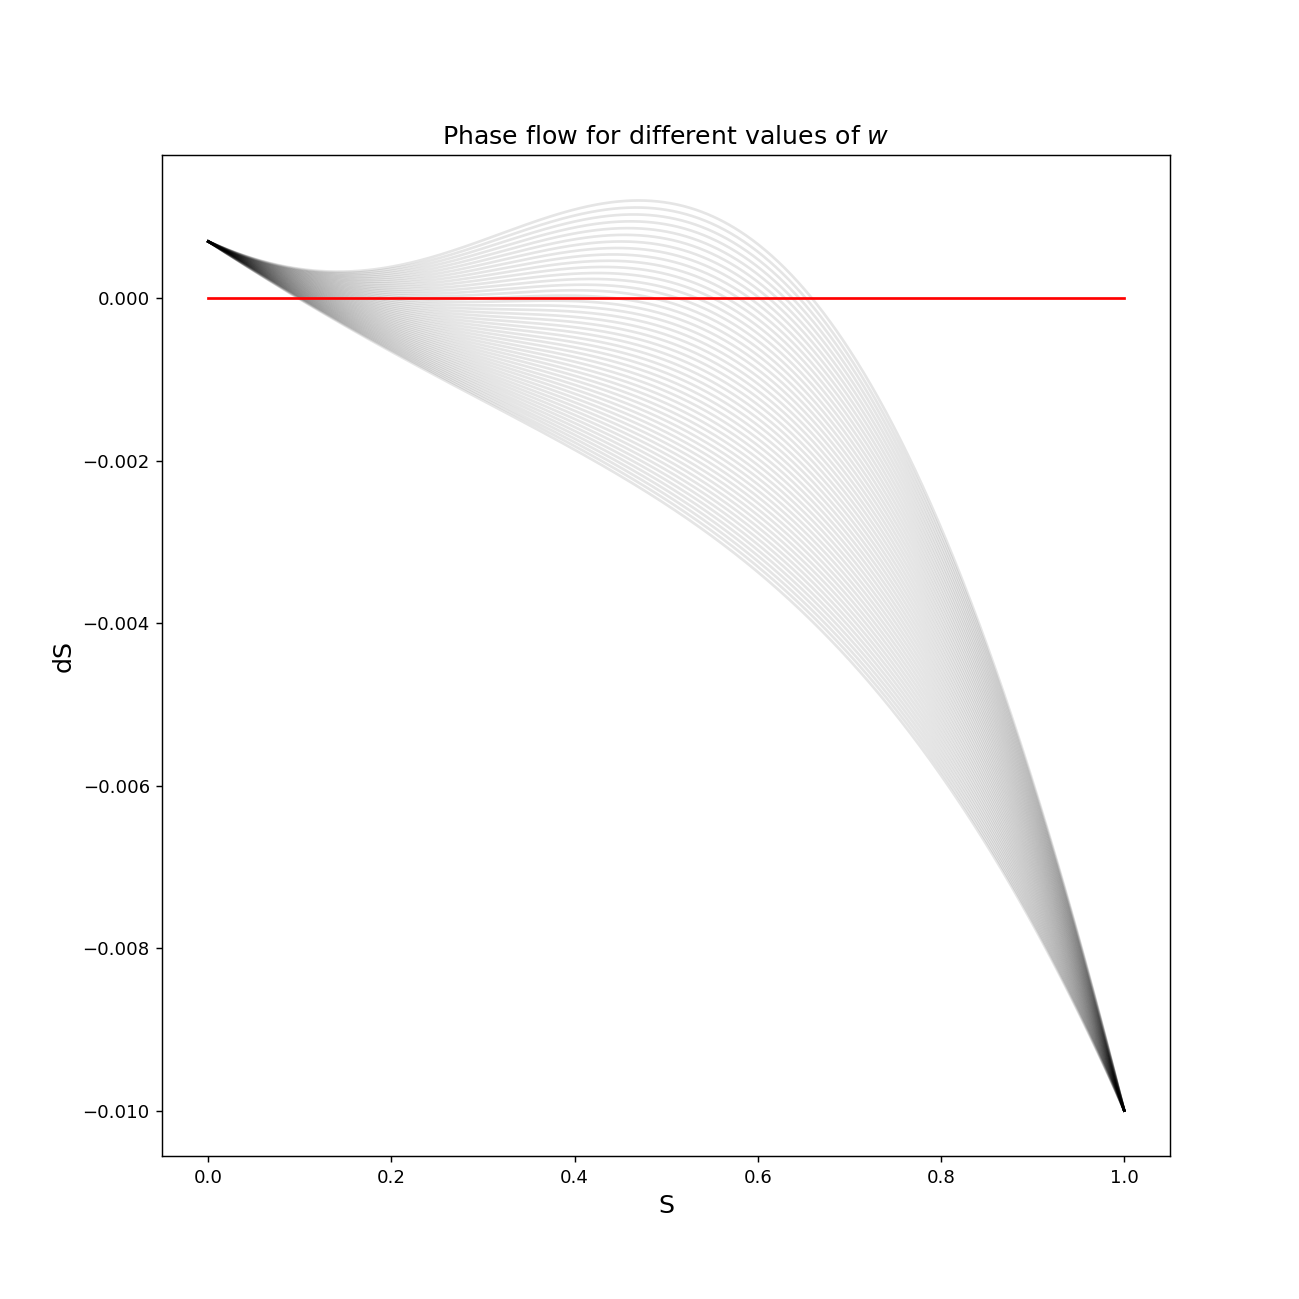

In [6]:
fig = figure(figsize=(10, 10))
for iw, w in enumerate(W):
    rww.w = np.array(w)
    dS = rww.dfun(S, C)  
    plot(S.flat, dS.flat, 'k', alpha=0.1)
plot([0, 0] , 'r')    
title('Phase flow for different values of $w$', fontsize=14)
xlabel('S', fontsize=14)
ylabel('dS', fontsize=14)
show()

<h2><font size="5" face="arial" color="black"> 1.2 Effects of the external input $I_o$ </font></h2>

In [7]:
Io = np.linspace(0.00, 0.42, num=50)
rww.w = np.array(1)

<IPython.core.display.Javascript object>


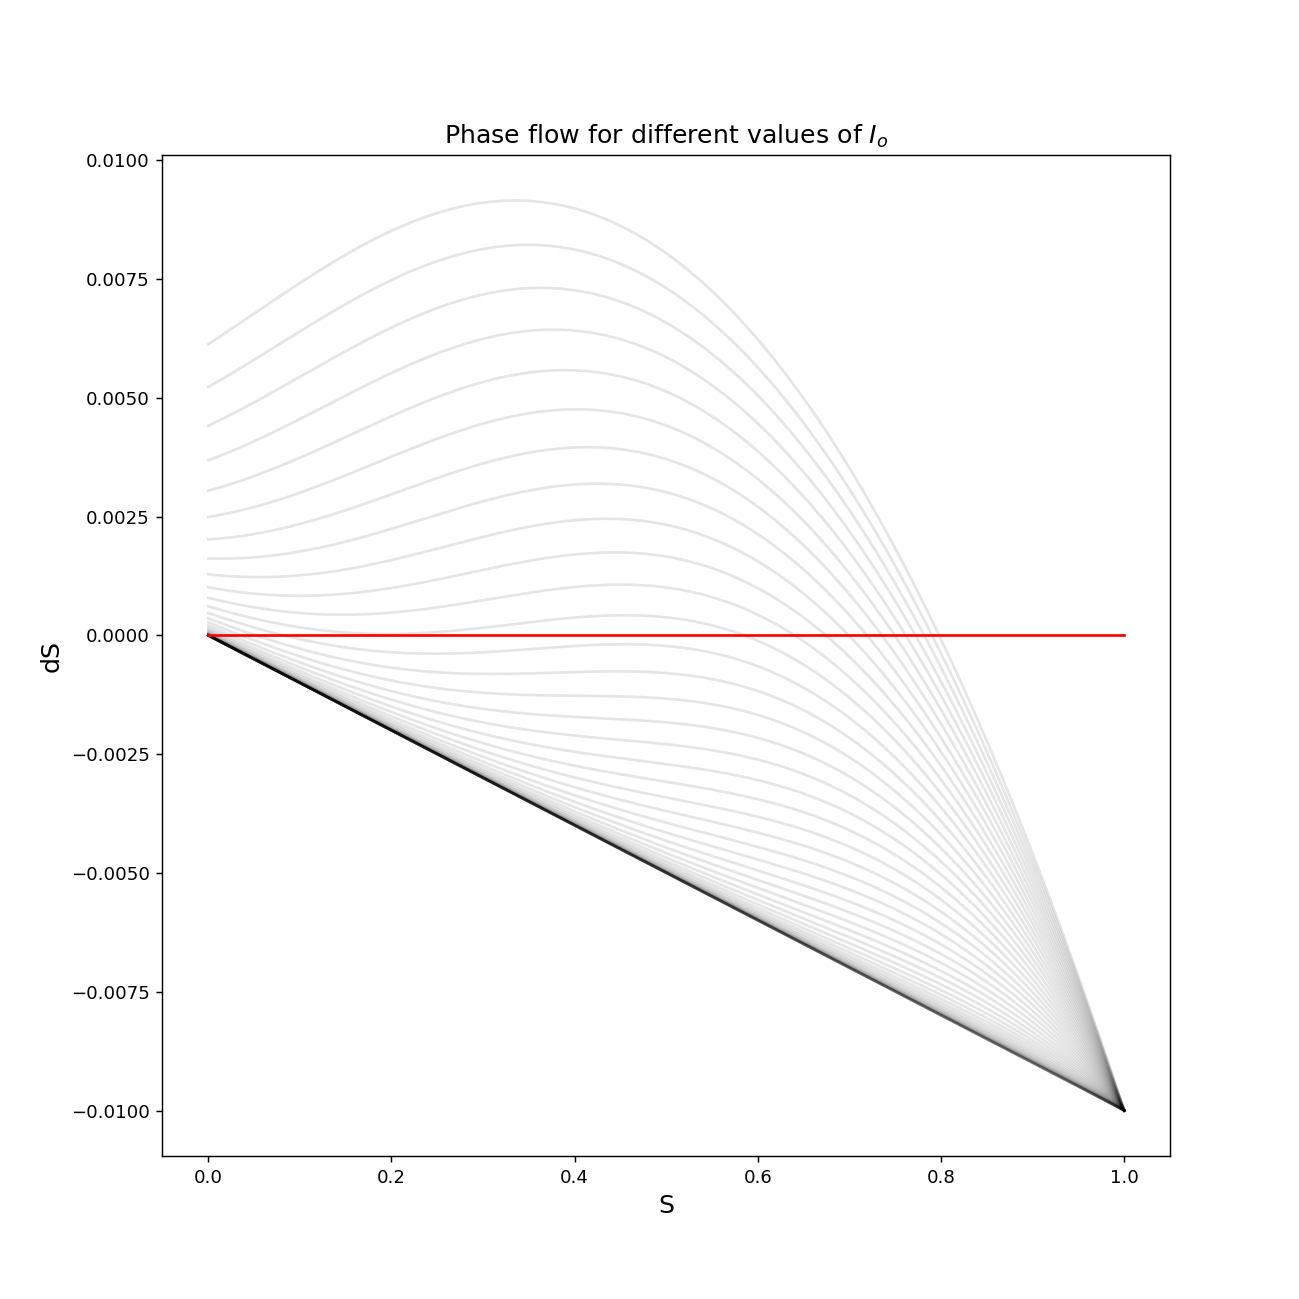

In [8]:
fig = figure(figsize=(10, 10))
for i, io in enumerate(Io):
    rww.I_o = np.array(io)
    dS = rww.dfun(S, C)
    plot(S.flat, dS.flat, 'k', alpha=0.1)
plot([0, 0] , 'r')    
title('Phase flow for different values of $I_o$', fontsize=14)
xlabel('S', fontsize=14)
ylabel('dS', fontsize=14)
show()

<h1><font size="6" face="arial" color="black">2. Dataset</font></h1>
<br>
<p><div style="text-align: justify"><font size="4.5" face="time roman">We will use the <b>default dataset</b> that is supplied with The Virtual Brain. To make things fully transparent, we will load the files from our local copy. To follow, change the path to the location of the dataset on your machine:</font></div></p>

In [9]:
datadir = os.path.abspath("./dataset")

<h1><font size="6" face="arial" color="black">3. Setting up the simulation</font></h1>

<p><div style="text-align: justify"><font size="4.5" face="time roman">The basic simulation of TVB consists of 5 main components. Each of these components is an object within TVB:</font></div></p>

## <font size="5" face="arial" color="black"> 3.1 Structural Connectivity</font></h3>

<p><div style="text-align: justify"><font size="4.5" face="time roman">We start with loading and visualizing the structural connectivity matrix.</font></div></p>

<IPython.core.display.Javascript object>


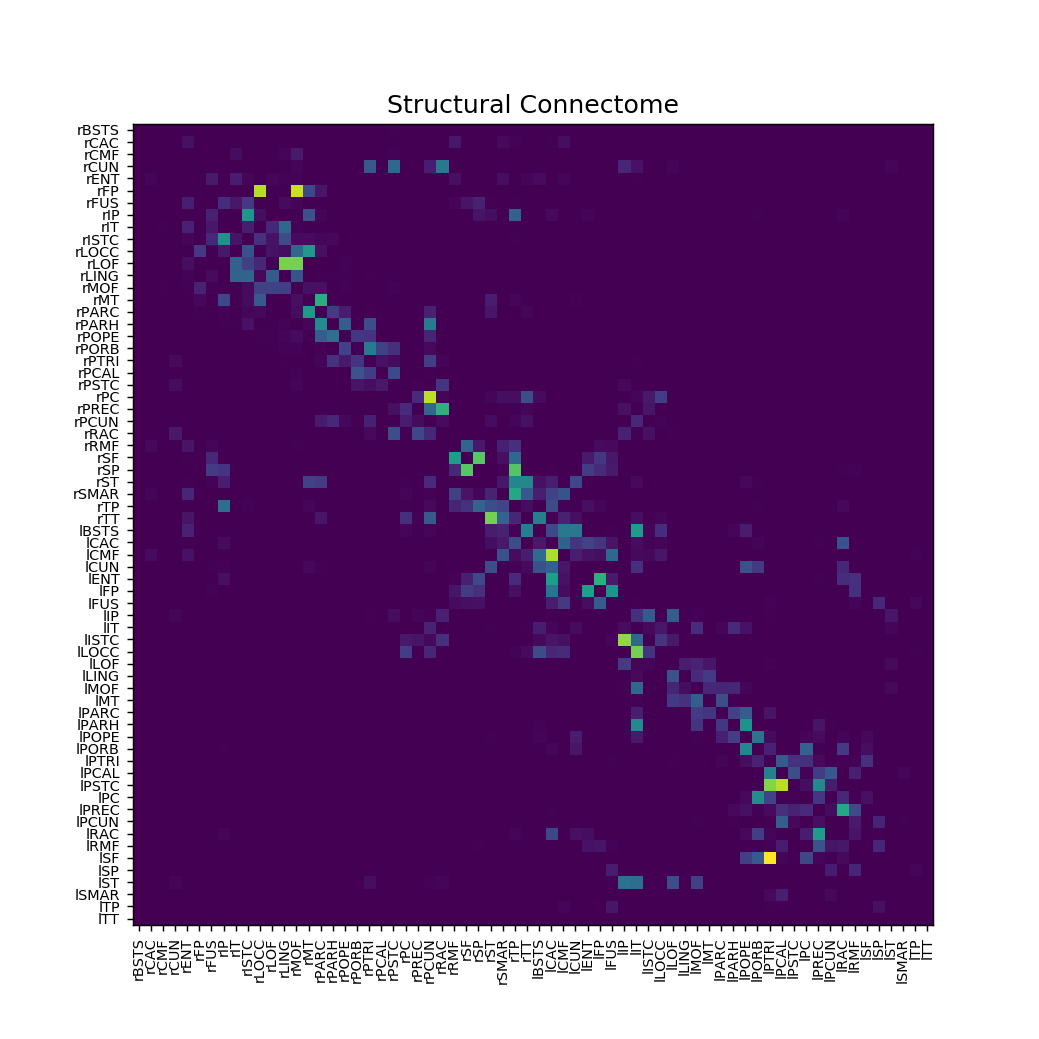

In [10]:
# Import the anatomical structural connectivity
con = connectivity.Connectivity.from_file(os.path.join(datadir, "connectivity_HagmannDeco66.zip"))
nregions = len(con.region_labels)
con.speed = np.array(np.inf)   #set the conduction speed to infinity
con.configure()

# Visualization
figure(figsize=(8,8))
imshow(con.weights, interpolation='nearest', aspect='equal')
title('Structural Connectome', fontsize=14)
xticks(range(0, nregions), con.region_labels, fontsize=8, rotation=90)
yticks(range(0, nregions), con.region_labels, fontsize=8)
show()

## <font size="5" face="arial" color="black"> 3.2 Model</font>

<p><div style="text-align: justify"><font size="4.5" face="time roman">A set of differential equations describing the local dynamics.</font></div></p>

In [11]:
# Initialise a Model
rww = models.ReducedWongWang(w=np.array(1), I_o=np.array(0.3))  #parameters used in Hansen et al. 2015
rww

## <font size="5" face="arial" color="black"> 3.3 Coupling function</font></h3>

<p><div style="text-align: justify"><font size="4.5" face="time roman">It is a function that is used to join the local model dynamics at distinct spatial locations.</font></div></p>

In [12]:
# Initialise a Coupling function
G = np.array(1.2)                        #global (long-range) coupling parameter: FC best fit (G=2.1) -- FCD best fit (G=1.2)
con_coupling = coupling.Scaling(a=G)

## <font size="5" face="arial" color="black"> 3.4 Integrator</font></h3>

<p><div style="text-align: justify"><font size="4.5" face="time roman">We use a stochastic integration scheme, and the noise is added. The shape of the noise must correspond to the number of state variables in neural mass models, here equal to 1. </font></div></p>

<p><div style="text-align: justify"><font size="4.5" face="time roman">We employ a standard Euler method for integrating the intrinsic eMFM dynamics while the coupling and the stochastic terms are integrated using Euler method. The step size for the simulation is 0.1.</font></div></p>

<p><div style="text-align: justify"><font size="4.5" face="time roman">By default in TVB, the stochastic method assumes that the standard deviation of the noise is a constant equal to: $\sqrt{(2\sigma)}$. </font></div></p>

In [13]:
# Initialise an Integrator scheme
dt = 0.1               #integration steps [ms]
nsigma = 0.001         #standard deviation of the noise

#eulerint = integrators.EulerDeterministic(dt=dt)

hiss = noise.Additive(nsig=np.array([(nsigma**2)/2]))  #Be careful: sigma:-> (sqrt(((2sigma))^2)/2)
eulerint = integrators.EulerStochastic(dt=dt, noise=hiss)

## <font size="5" face="arial" color="black"> 3.5 Monitors</font></h3>

<p><div style="text-align: justify"><font size="4.5" face="time roman">We will now set the monitors: a temporal average, and to relate the simulated neural activity to recent fMRI studies, we will generate BOLD signal for each regions by using a hemodynamic model with the use of the monitor <b>Bold</b>.<br />
</font></div></p>

In [14]:
# Initialise some Monitors with period in physical time
mon_tavg = monitors.TemporalAverage(period=1) #in ms
mon_bold = monitors.Bold(period=100)         #in ms 

#Bundle them
what_to_watch = (mon_tavg, mon_bold)

***

<h1 align="center"><font size="6"face="arial" color="black">Go! Simulate</font></h1>

<p><div style="text-align: justify"><font size="4.5" face="time roman">We can then configure and run the <b>Simulator</b>.</font></div></p>

In [15]:
# Initialise the Simulator
sim = simulator.Simulator(model=rww,
                          connectivity=con,
                          conduction_speed=np.float(con.speed),
                          coupling=con_coupling,
                          integrator=eulerint,
                          monitors=what_to_watch)

# In the paper hansen et al 2015, the initial conditions are set to 0.001
sim.initial_conditions = 0.001 * np.ones((1, 1, con.weights.shape[0], 1))    #size=[time, stat. vars, nodes, modes]

sim.configure()

In [16]:
# Perform the simulation
(tavg_time, tavg), (bold_time, bold) = sim.run(simulation_length=20000)

***

<h1 align="center"><font size="6"face="arial" color="black">Visualize our simulation</font></h1>

<p><div style="text-align: justify"><font size="4.5" face="time roman">And finally, we can look at the results of our simulation in terms of time series:</b>.</font></div></p>

In [17]:
# Remove the single-dimensional entries (i.e. number of variables and number of modes)
tavg = np.squeeze(tavg)
bold = np.squeeze(bold)

<IPython.core.display.Javascript object>


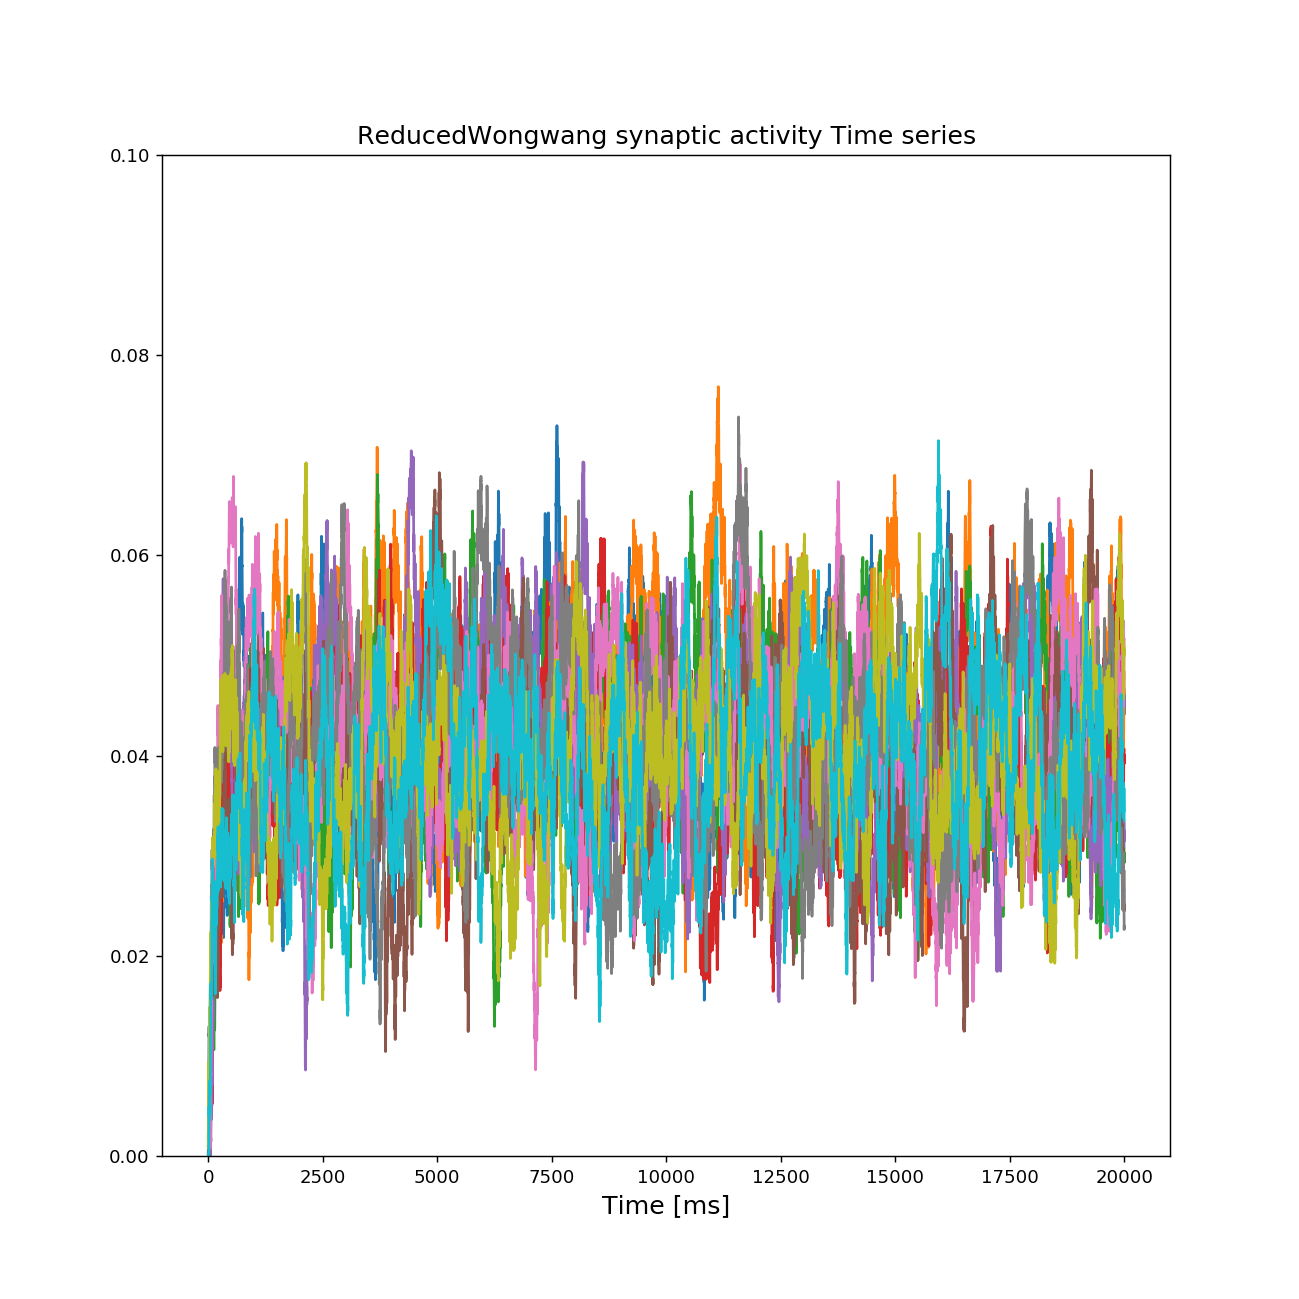

In [18]:
# Plot the temporal average time series of some nodes
figure(figsize=(10,10))
plot(tavg_time, tavg[:, 10:20])
title('ReducedWongwang synaptic activity Time series', fontsize=14)
ylim([0, 0.1])
xlabel('Time [ms]', fontsize=14)
show()

<IPython.core.display.Javascript object>


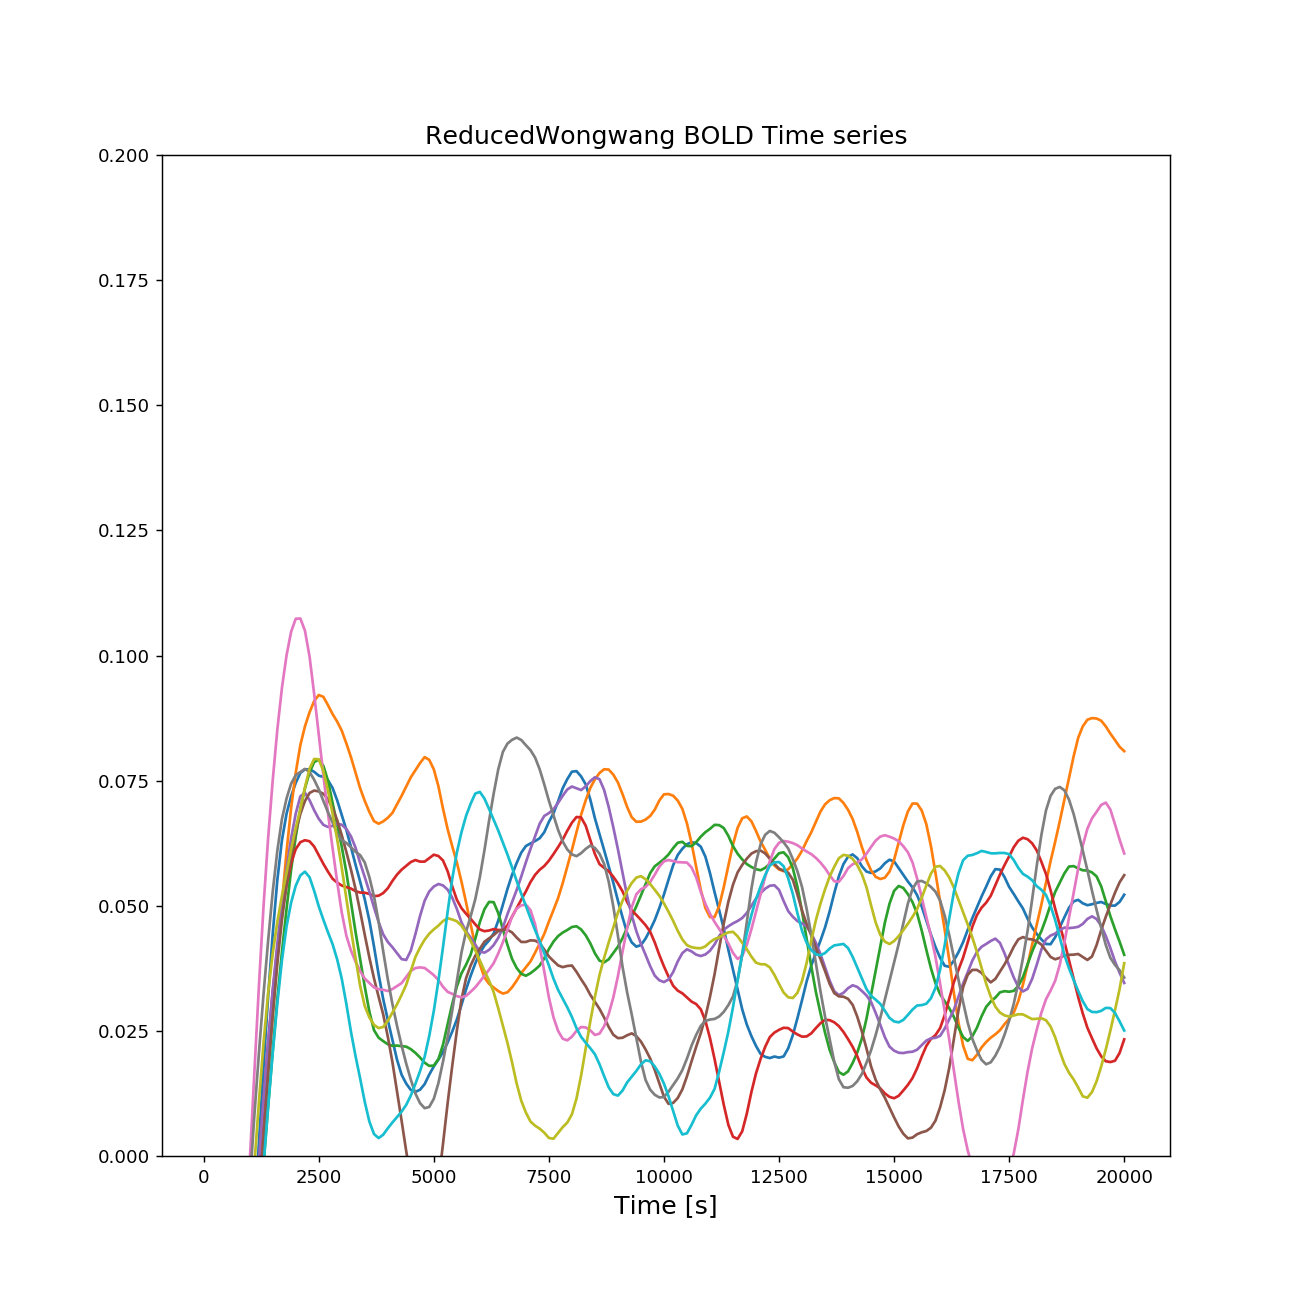

In [19]:
# Plot the BOLD time series of some nodes
figure(figsize=(10,10))
plot(bold_time, bold[:, 10:20])
title('ReducedWongwang BOLD Time series', fontsize=14)
ylim([0, 0.2])
xlabel('Time [s]', fontsize=14)
show()

***

<h1><font size="6"face="arial" color="black"> 4. Analyse fMRI BOLD signal</font></h1>

## <font size="5" face="arial" color="black"> 4.1 Functional Connectivity (FC)</font>

<p><div style="text-align: justify"><font size="4.5" face="time roman">Next, to quickly assess the presence of a network structure in the time series, we compute the Functional Connectivity by calculating the <b>Pearson correlation</b> between the BOLD signals of any two brain areas.</font></div></p>

In [20]:
# Load full-length BOLD signal of 20 min
bold = np.load(os.path.join(datadir, "rww_eMFM_con_HagmannDeco66_bolds_coupl_2.1_nsigma_0.001.npy"))

# Discarded first 10,000 ms
data = bold[6:(int(1200000/2000)), :]          

# Build a 4D TVB matrix (only need in outside analysis)
data = data[:, np.newaxis, :, np.newaxis] #reminder: TVB matrix size=([time, stat vars, nodes, modes])

<IPython.core.display.Javascript object>


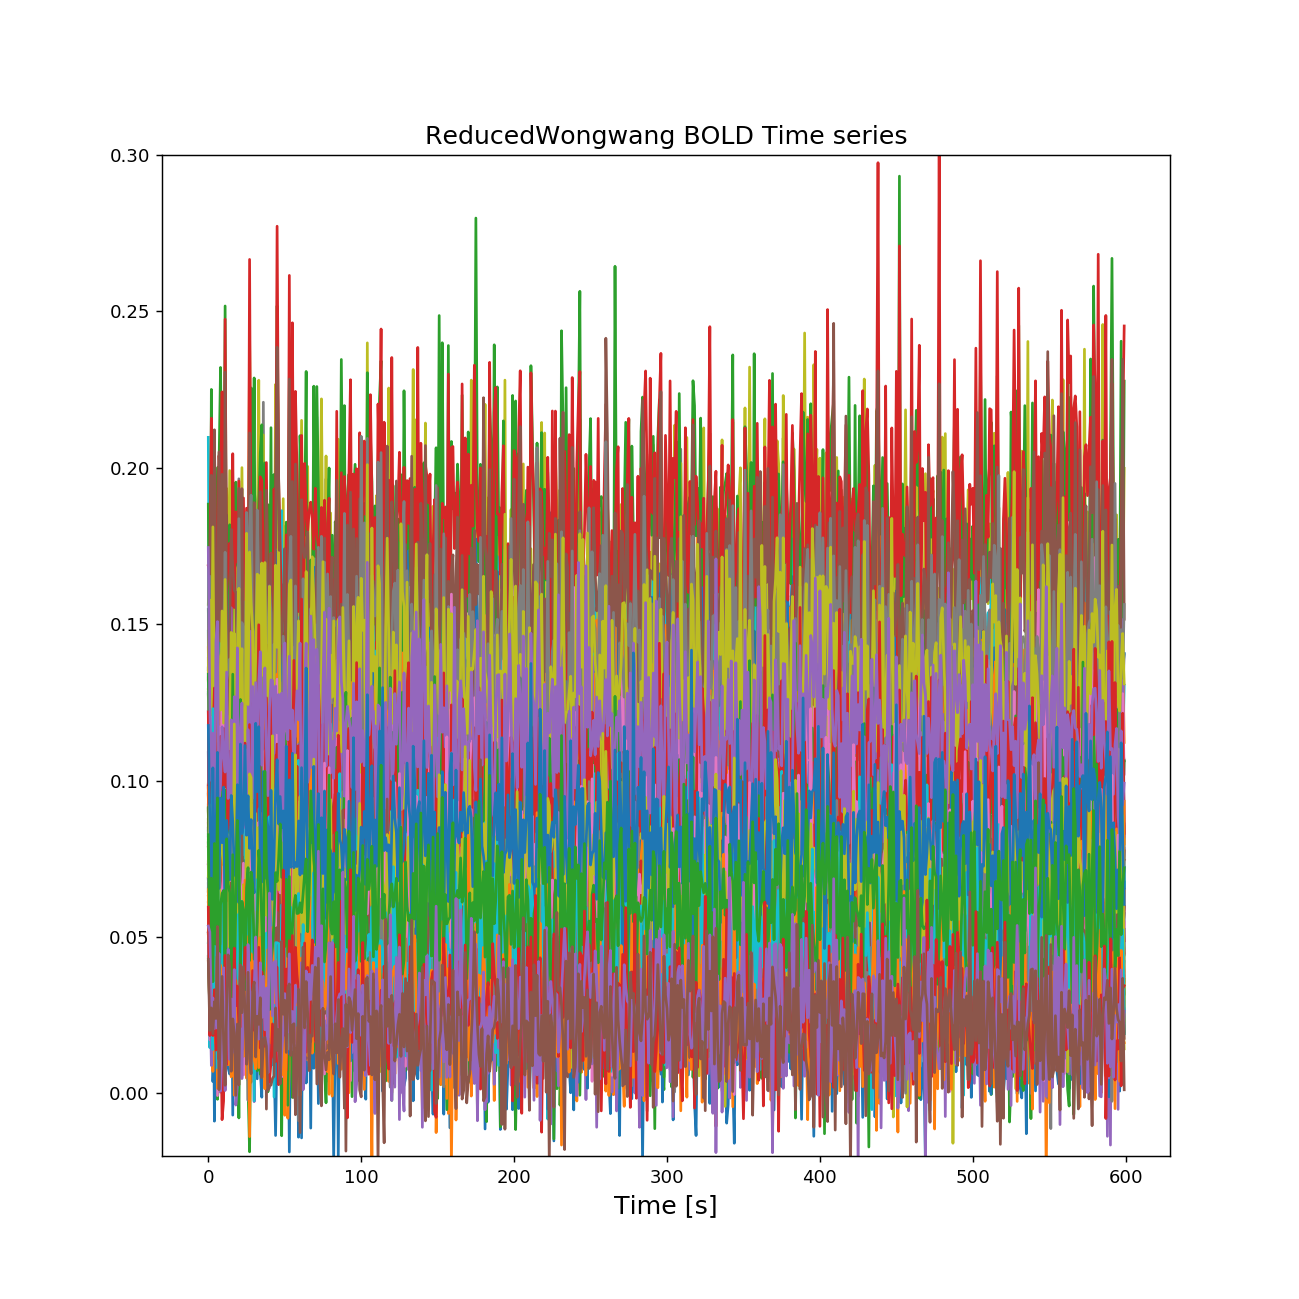

In [21]:
# Plot the BOLD time series

# Plot the BOLD time series of some nodes
figure(figsize=(10,10))
plot(range(int(1200000/2000)), bold)
title('ReducedWongwang BOLD Time series', fontsize=14)
ylim([-0.02, 0.3])
xlabel('Time [s]', fontsize=14)
show()

In [22]:
# Build a TimeSeries Dataype
period = 2000                              #in ms
tsr = TimeSeriesRegion(connectivity=con,
                       data=data,
                       sample_period=period)
tsr.configure()

In [23]:
def eval_fc(tsr):
    input_shape = tsr.data.shape
    result_shape = (input_shape[2], input_shape[2], input_shape[1], input_shape[3])
    result = numpy.zeros(result_shape)

    for mode in range(result_shape[3]):
        for var in range(result_shape[2]):
            data = tsr.data[:,var,:, mode].squeeze()
            result[:, :, var, mode] = numpy.corrcoef(data.T)

    corr_coeff = graph.CorrelationCoefficients(source=tsr, array_data=result)
    return corr_coeff

In [24]:
# Compute FC
corrcoeff_data = eval_fc(tsr)
FC = corrcoeff_data.array_data[..., 0, 0]

<IPython.core.display.Javascript object>


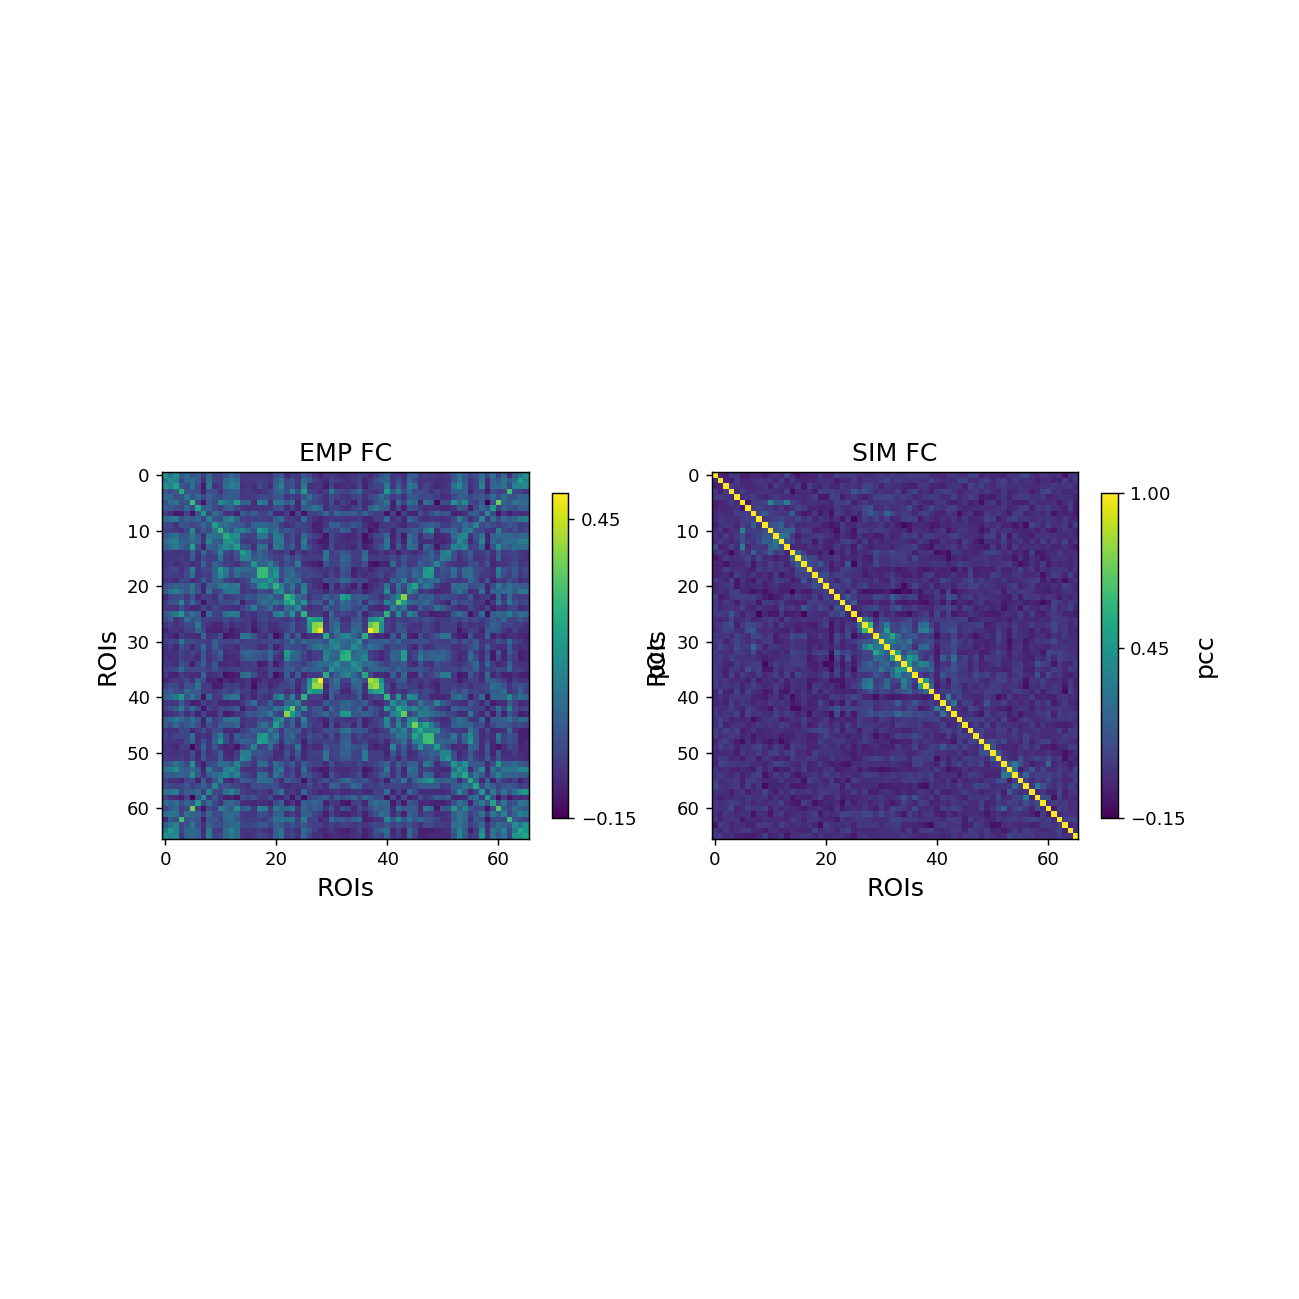

In [25]:
# Visualize and compare the empirical and simulated FC
figure(figsize=(10,10))

#empirical FC
subplot(121)
# load empirical FC
empFC = np.load(os.path.join(datadir, 'Hagmann_empFC_avg.npy'))
p1=imshow(empFC, interpolation='nearest', aspect='equal')
xlabel('ROIs', fontsize=14); ylabel('ROIs', fontsize=14)
title('EMP FC', fontsize=14)
cb1=colorbar(p1, shrink=0.325, ticks=[-0.15, 0.45,1])
cb1.set_label('pcc', fontsize=14)

#simulated FC
subplot(122)
p2=imshow(FC, interpolation='nearest', aspect='equal')
xlabel('ROIs', fontsize=14); ylabel('ROIs', fontsize=14)
title('SIM FC', fontsize=14)
cb2=colorbar(p2, shrink=0.325, ticks=[-0.15, 0.45,1])
cb2.set_label('pcc', fontsize=14)
show()

<p><div style="text-align: justify"><font size="4.5" face="time roman">We compare the FC matrix of the empirical data and the simulated by adopting as a measure of similarity between the two matrices the Pearson correlation between corresponding elements of the <b>upper (or lower)</b> triangular part of the matrices.</font></div></p>

In [26]:
# Compute the Pearson correlation between the empirical and simulated FC
# Use only elements of the upper triangular matrix

empFCt = empFC[np.triu_indices(empFC.shape[0], 1)] 
simFCt =    FC[np.triu_indices(   FC.shape[0], 1)] 

pcc = np.corrcoef(empFCt.ravel(), simFCt.ravel())[0, 1]
pcc

0.35796946500973853

## <font size="5" face="arial" color="black"> 4.2 Functional Connectivity Dynamic (FCD)</font>

<p><div style="text-align: justify"><font size="4.5" face="time roman">Each full-length BOLD signal of 20 min is split up into windows of 60 seconds, overlapping by 58 seconds.</font></div></p>

<p><div style="text-align: justify"><font size="4.5" face="time roman">First we compare the results of the simulation for the optimal parameters for FC (but suboptimal for FCD).</font></div></p>

In [27]:
# Load full-length BOLD signal of 20 min
bold = np.load(os.path.join(datadir, 'rww_eMFM_con_HagmannDeco66_bolds_coupl_2.1_nsigma_0.001.npy'))

# Discarded first 10,000 ms
data = bold[6:int(1200000/2000), :]          

# Build a 4D TVB matrix (only need in outside analysis)
data = data[:, np.newaxis, :, np.newaxis] #reminder: TVB matrix size=([time, stat vars, nodes, modes])

# Build Timeseries
tsr = TimeSeriesRegion(connectivity = con,
                      data = data,
                      sample_period = 2000)
tsr.configure()

In [28]:
def eval_fcd(tsr,sp,sw):
    # Pass sp and sw in the right time reference (means considering the sample period)
    sp = float(sp) / tsr.sample_period
    sw = float(sw) / tsr.sample_period

    input_shape = tsr.data.shape
    fcd_points = int((input_shape[0] - sw) / sp)
    result_shape = (fcd_points, fcd_points, input_shape[1], input_shape[3])

    fcd = np.zeros(result_shape)
    fc_stream = {}  # dict where the fc calculated over the sliding window will be stored
    for mode in range(result_shape[3]):
        for var in range(result_shape[2]):
            start = -sp  # in order to well initialize the first starting point of the FC stream
            for nfcd in range(result_shape[0]):
                start += sp
                current_slice = tuple([slice(int(start), int(start + sw) + 1), slice(var, var + 1),
                                       slice(input_shape[2]), slice(mode, mode + 1)])
                data = tsr.data[current_slice].squeeze()
                fc = np.corrcoef(data.T)
                # the triangular part of the fc is organized as a vector, excluding the diagonal (always ones)
                triangular = np.triu_indices(len(fc), 1)
                fc_stream[nfcd] = fc[triangular]
            for i in range(result_shape[0]):
                j = i
                while j < result_shape[0]:
                    fci = fc_stream[i]
                    fcj = fc_stream[j]
                    fcd[i, j, var, mode] = np.corrcoef(fci, fcj)[0, 1]
                    fcd[j, i, var, mode] = fcd[i, j, var, mode]
                    j += 1
    return fcd

In [29]:
# Initialise the parameters
wind_len=60e3   #size of sliding window in ms
wind_sp=2e3     #size spanning window in ms

# Compute FCD
fcd_data = eval_fcd(tsr, sw=wind_len, sp=wind_sp)
FCD = fcd_data[:,:,0,0]

<IPython.core.display.Javascript object>


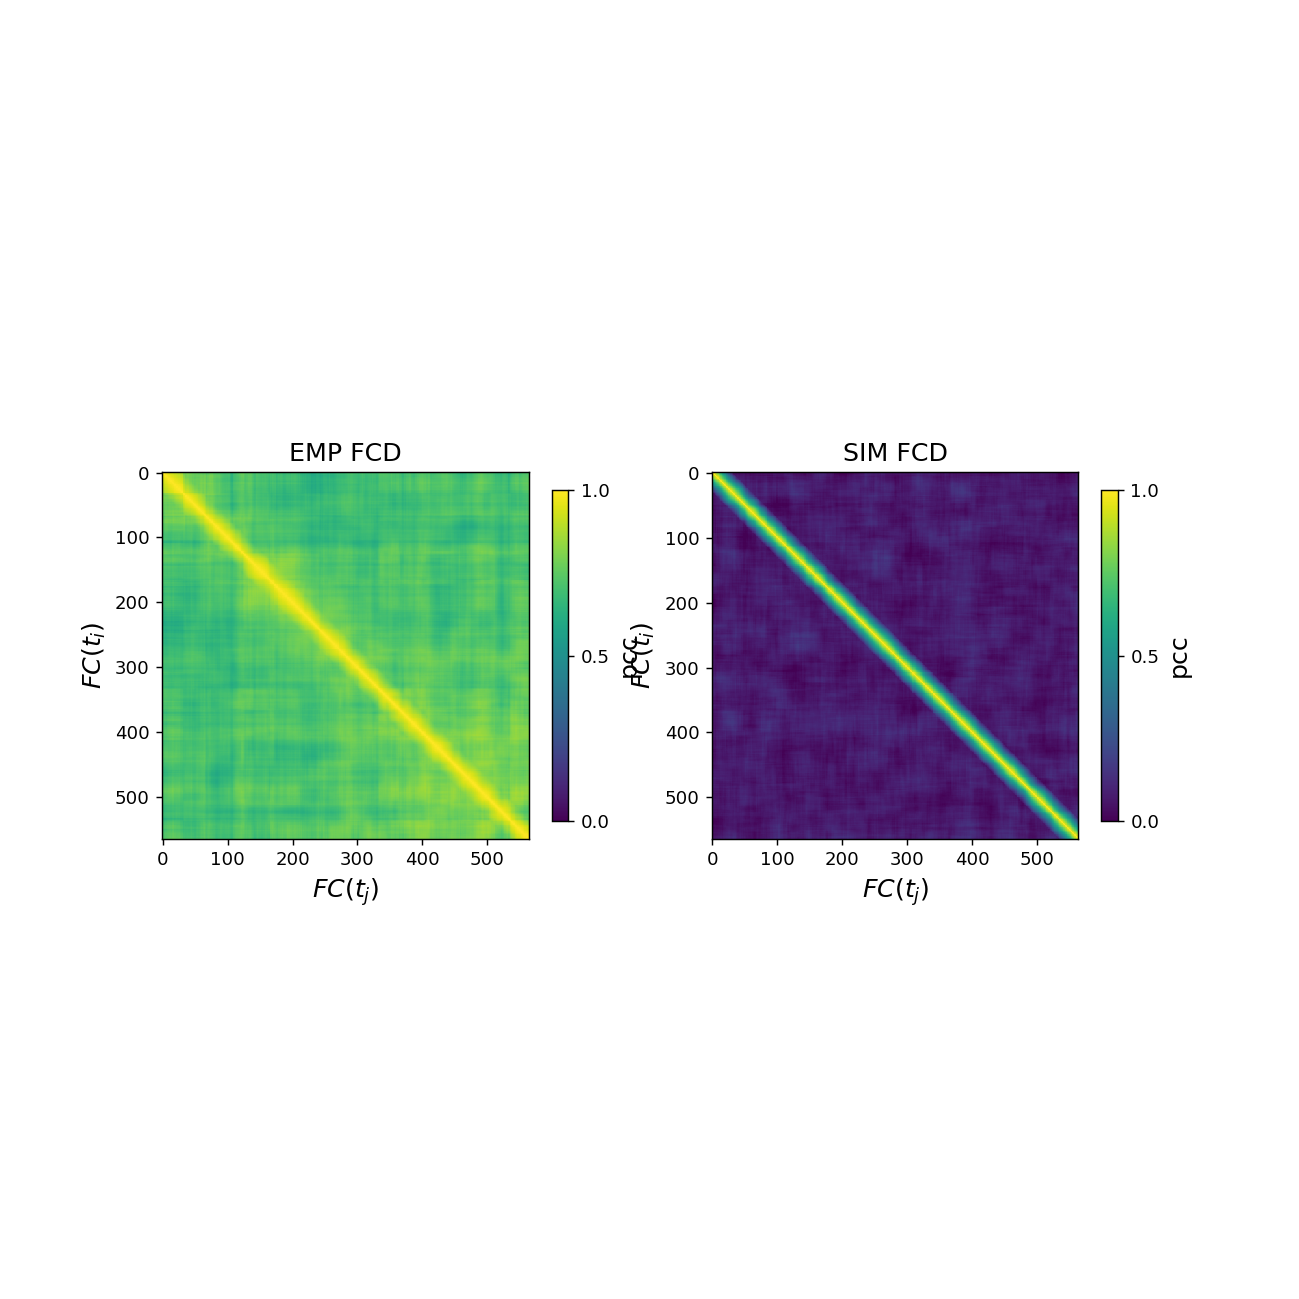

In [30]:
# Visualize and compare the empirical and simulated FCD
figure(figsize=(10, 10))

#emp
subplot(121)
# Load empirical FCD
empFCD = np.load(os.path.join(datadir, 'Hagmann_empFCD_avg.npy'))
p1=imshow(empFCD, interpolation='nearest', aspect='equal')
xlabel('$FC(t_{j})$', fontsize=14); ylabel('$FC(t_{i})$', fontsize=14)
title('EMP FCD', fontsize=14)
cb1=colorbar(p1, shrink=0.33, ticks=[0, 0.5, 1])
clim([0., 1])
cb1.set_label('pcc', fontsize=14)

#sim
subplot(122)
p2=imshow(FCD, interpolation='nearest', aspect='equal')
xlabel('$FC(t_{j})$', fontsize=14); ylabel('$FC(t_{i})$', fontsize=14)
title('SIM FCD', fontsize=14)
cb2=colorbar(p2, shrink=0.33, ticks=[0, 0.5, 1])
clim([0, 1])
cb2.set_label('pcc', fontsize=14)
show()


<p><div style="text-align: justify"><font size="4.5" face="time roman">Now we compare the results of the simulation for parameters chosen for reasonable FCD.</font></div></p>

In [31]:
# Load full-length BOLD signal of 20 min
bold = np.load(os.path.join(datadir, 'rww_eMFM_con_HagmannDeco66_bolds_coupl_1.2_nsigma_0.007.npy'))

# Discarded first 10,000 ms
data = bold[6:int(1200000/2000), :]          

# Build a 4D TVB matrix (only need in outside analysis)
data = data[:, np.newaxis, :, np.newaxis] #reminder: TVB matrix size=([time, stat vars, nodes, modes])

# Build Timeseries
tsr = TimeSeriesRegion(connectivity = con,
                      data = data,
                      sample_period = 2000)
tsr.configure()

In [32]:
# Initialise the parameters
wind_len=60e3   #size of sliding window in ms
wind_sp=2e3     #size spanning window in ms

# Compute FCD
fcd_data = eval_fcd(tsr, sw=wind_len, sp=wind_sp)
FCD = fcd_data[:,:,0,0]

<IPython.core.display.Javascript object>


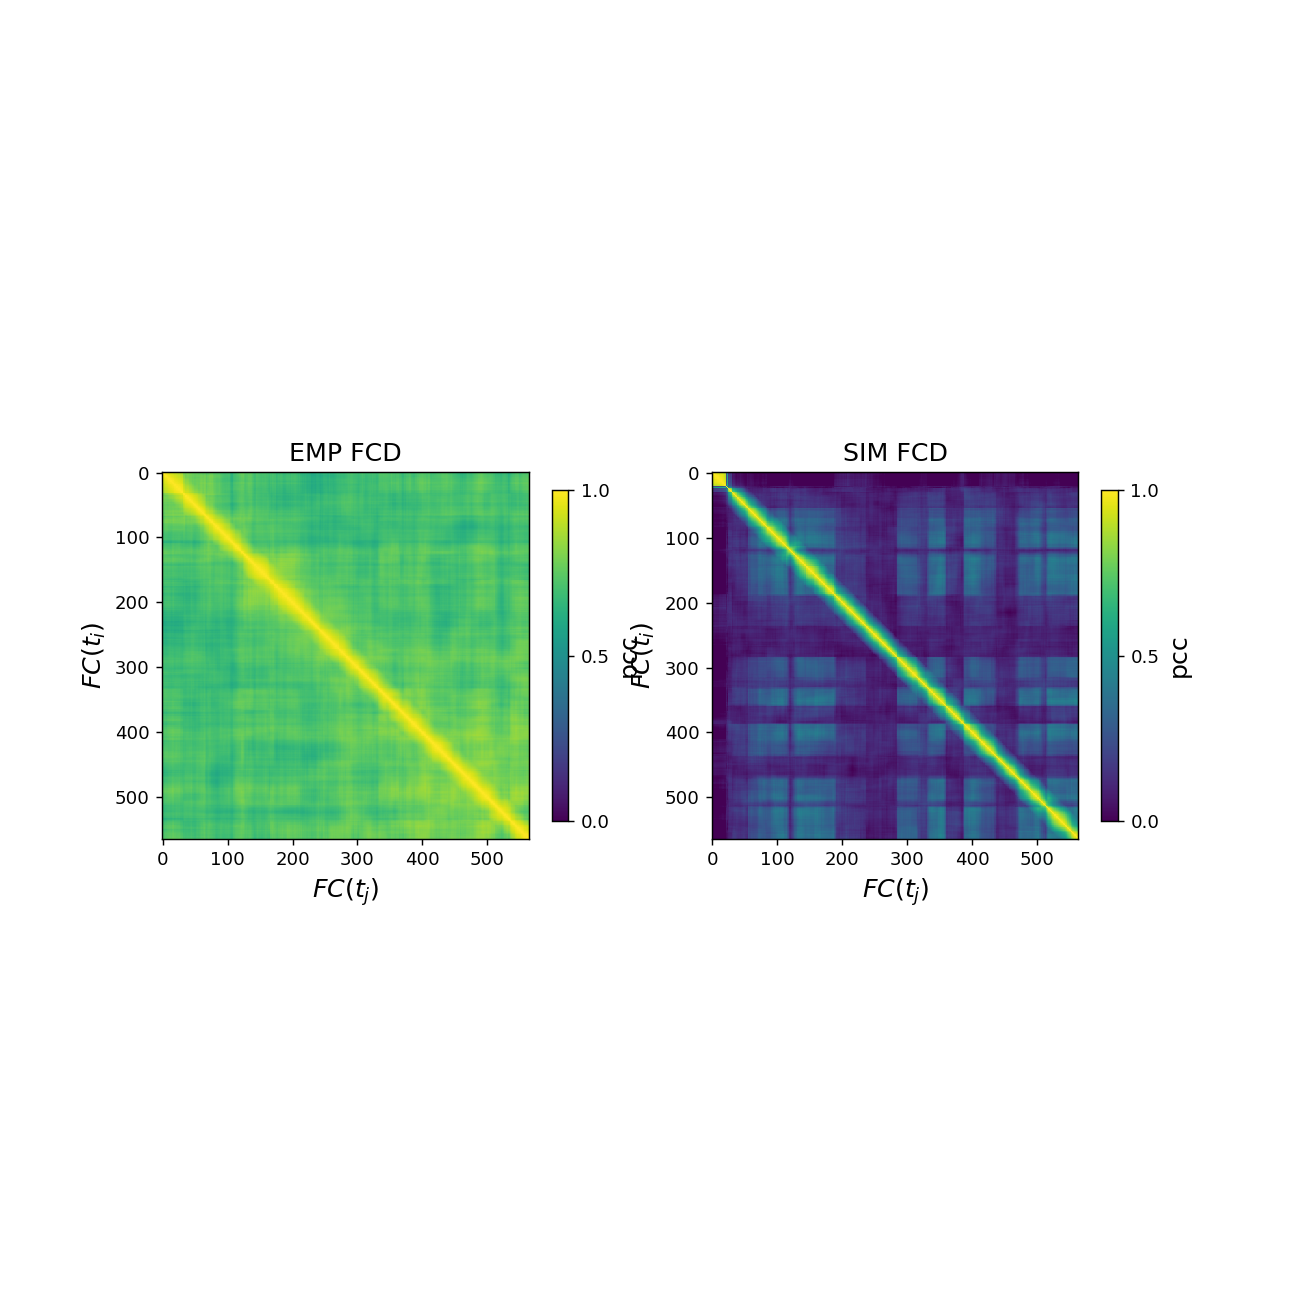

In [33]:
# Visualize and compare the empirical and simulated FCD
figure(figsize=(10, 10))

#emp
subplot(121)
# Load empirical FCD
empFCD = np.load(os.path.join(datadir, 'Hagmann_empFCD_avg.npy'))
p1=imshow(empFCD, interpolation='nearest', aspect='equal')
xlabel('$FC(t_{j})$', fontsize=14); ylabel('$FC(t_{i})$', fontsize=14)
title('EMP FCD', fontsize=14)
cb1=colorbar(p1, shrink=0.33, ticks=[0, 0.5, 1])
clim([0, 1])
cb1.set_label('pcc', fontsize=14)

#sim
subplot(122)
p2=imshow(FCD, interpolation='nearest', aspect='equal')
xlabel('$FC(t_{j})$', fontsize=14); ylabel('$FC(t_{i})$', fontsize=14)
title('SIM FCD', fontsize=14)
cb2=colorbar(p2, shrink=0.33, ticks=[0, 0.5, 1])
clim([0, 1])
cb2.set_label('pcc', fontsize=14)
show()

<h1><font size="6" face="arial" color="#609BC4">That is all folks -- so, what now?</font></h1>

***

<p><div style="text-align: justify"><font size="4.5" face="time roman">And that is it for this tutorial. These results are starting point for modelling resting state, from which we can base our next simulations.</p>

<br></br>
<p><div style="text-align: justify"><font size="4.5" face="time roman">We hope that this has been a useful tutorial and we welcome any comments or questions.</font></div></p>